## Conservation laws

### Conservation of Mass

$$
\begin{equation}
\frac{\partial}{\partial t}\int_{\text{cv}}\rho \, dV + \int_{\text{cs}}\rho \, u\, dA =0
\end{equation}
$$

### Traffic Flow
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}

where,
\begin{equation}
F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation},

with initial conditions,
\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
\rho_{\rm max}\frac{x}{2} & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}.

In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def rho_green_light(x, rho_light):
    """
    Computes the "green light" initial condition. It consists of a 
    shock with a linear distribution behind it.
    
    Parameters
    ----------
    x : np.ndaray
        Locations on the road as a 1D array of floats.
    rho_light : float
        Car density at the stoplight.
    
    Returns
    -------
    rho : np.ndarray
        The initial car density along the road as a 1D array of floats.
    """
    
    rho = np.zeros_like(x)
    mask = np.where(x < 2.0)
    rho[mask] = rho_light * x[mask] / 2.0
    
    return rho

In [4]:
# set parameters
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 30  # number of time step to compute
u_max = 1.0  # maximum speed allowed on the road
rho_max = 10.0  # maximum car density allowed on the road
rho_light = 10.0  # car density at the stoplight

# discretize the road
x = np.linspace(0.0, L, num=nx)

# compute the initial traffic density
rho0 = rho_green_light(x, rho_light)

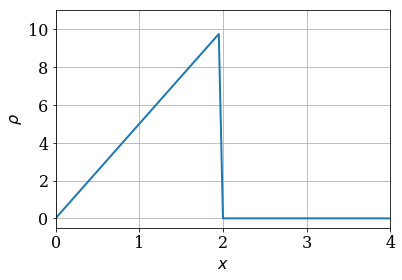

In [5]:
# plot the initial car density on the road.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
pyplot.plot(x, rho0, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0);

In [6]:
def flux(rho, u_max, rho_max):
    """
    Computes the traffic flux F = V * rho.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats
    u_max : float
        Maximum speed allowed on the road
    rho_max : float
        Maximum car density allowed on the road
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats
    """
    
    F = rho * u_max * (1.0 - rho / rho_max)
    
    return F

### Forward-time/backward-space (FTBS)

\begin{equation}
\frac{\rho^{n+1}_i- \rho^n_{i}}{\Delta t}+ \frac{F^n_{i}-F^n_{i-1}}{\Delta x}=0
\end{equation}

In [7]:
def ftbs(rho0, nt, dt, dx, bc_value, *args):
    """
    Computes the history of the traffic density on the road at a 
    certain time given the initial traffic density.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial car density along the road as a 1D array of floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    bc_value : float
        The constant density at the first station
    args : list or tuple
        Positional arguments to be passed to the flux function
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
    """
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    
    for n in range(nt):
        # compute the flux
        F = flux(rho, *args)
        
        # advance in time
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        
        # set the left boundary condition
        rho[0] = bc_value
        
        # record the time-step solution
        rho_hist.append(rho.copy())
        
    return rho_hist

In [8]:
# set the time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = ftbs(rho0, nt, dt, dx, rho0[0], u_max, rho_max)

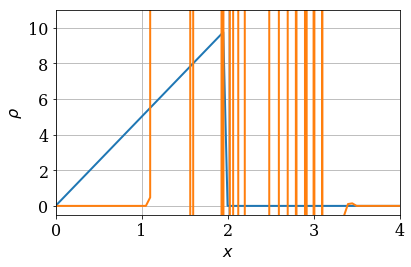

In [9]:
# plot the initial traffic density
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
pyplot.plot(x, rho0,
                    color='C0', linestyle='-', linewidth=2)[0]

# plot the final rho
pyplot.plot(x, rho_hist[-1],
                    color='C1', linestyle='-', linewidth=2)[0]

pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0)
fig.tight_layout()

In [10]:
from matplotlib import animation
from IPython.display import HTML

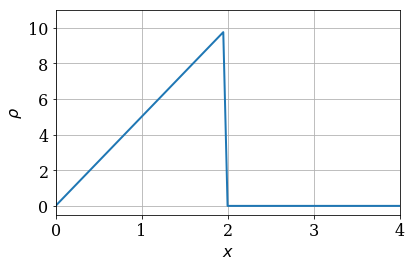

In [11]:
# plot the initial traffic density
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                    color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0)
fig.tight_layout()

In [12]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution
    """
    
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [13]:
# create an animation of the traffic density
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# display the video
HTML(anim.to_html5_video())

The solution blows up.
The issue is that a scheme that is backward in space is unstable for negative values of the wave speed.

For this case, the initial conditions are,
\begin{equation}
u_{\rm wave} = \frac{\partial F}{\partial \rho} = u_{\rm max} \left( 1-2\frac{\rho}{\rho_{\rm max}} \right)
\end{equation}.
This means that the wave speed changes sign at $\rho = \rho_{\rm max}/2$, and this makes he backward space solution unstable.

## Upwind Schemes

Changing ICs such that $\rho \leq \rho_{\rm max}/2$ always,
\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
2.5 x & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\ \end{array} \right.\end{equation}

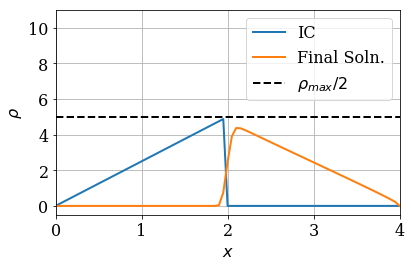

In [20]:
# modify some parameters
nt = 40  # number of time step to compute
rho_light = 5.0  # car density at the stoplight

# compute the initial traffic density
rho0 = rho_green_light(x, rho_light)

# Compute the traffic density at all time steps.
rho_hist = ftbs(rho0, nt, dt, dx, rho0[0], u_max, rho_max)


fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
pyplot.hlines(rho_max / 2.0, 0.0, L,
              label=r'$\rho_{max} / 2$',
              color='black', linestyle='--', linewidth=2)
pyplot.plot(x, rho0,
            label='IC',
            color='C0', linestyle='-', linewidth=2)
pyplot.plot(x, rho_hist[-1],
            label='Final Soln.',
            color='C1', linestyle='-', linewidth=2);
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0)
fig.tight_layout()

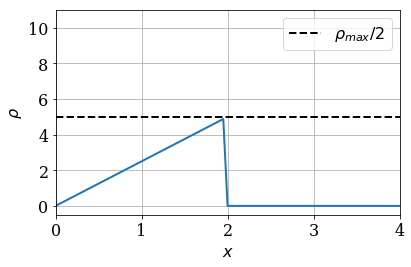

In [21]:
# plot the initial traffic density
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.hlines(rho_max / 2.0, 0.0, L,
              label=r'$\rho_{max} / 2$',
              color='black', linestyle='--', linewidth=2)
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0)
fig.tight_layout()